# Tugas Eksplorasi ResNet Kelompok 13 NGASAL
Mata Kuliah: Pembelajaran Mendalam (IF25-40401) RA 
Program Studi Teknik Informatika – Institut Teknologi Sumatera
### Nama Anggota Kelompok:
- Bayu Prameswara Haris - 122140219
- Jason Surya Padantya - 122140237
- Abu Bakar Siddiq Siregar - 122140164


## 1. Instalasi Dependensi

In [13]:
import os, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report

## 2. Konfigurasi

In [14]:
IMG_PATH = "train"  
CSV_PATH = "train.csv"
BATCH_SIZE = 16
EPOCHS = 15       
LR = 1e-4         
Random_Seed = 42 

## 3. Data Loader

In [15]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        self.idx_to_class = {v: k for k, v in self.label_map.items()}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_PATH, transform=transform)
generator = torch.Generator().manual_seed(Random_Seed)  
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 4. Modifikasi Model

In [16]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample or self._default_downsample(inplanes, planes, stride)

    def _default_downsample(self, inplanes, planes, stride):
        if stride != 1 or inplanes != planes * self.expansion:
            return nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
        return None

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Opsi D: Pre-activation Block
class PreActBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample

    def forward(self, x):
        shortcut = x  # tetap input asli
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)  # terapkan di input asli
        # Ensure dimensions match before addition
        if out.size() != shortcut.size():
            raise RuntimeError(f"Dimension mismatch: out {out.size()} vs shortcut {shortcut.size()}")
        out += shortcut
        return out

# Opsi E: Kernel/Stride Modified Block
class KernelStrideModifiedBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        # conv pertama pakai 5x5, padding=2 supaya ukuran feature map tetap sama
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=5, stride=stride,
                               padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # conv kedua tetap 3x3 standar
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

## 5. Builder

In [17]:
def resnet34(num_classes=5):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

def preact_resnet34(num_classes=5):
    return ResNet(PreActBasicBlock, [3,4,6,3], num_classes=num_classes)

def kernelstride_resnet34(num_classes=5):
    return ResNet(KernelStrideModifiedBlock, [3,4,6,3], num_classes=num_classes)

## 6. Training Utilities

In [18]:
criterion = nn.CrossEntropyLoss()

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    return running_loss / len(loader), 100.0 * correct / total

def evaluate_classification_report(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    report = classification_report(
        y_true, y_pred, target_names=class_names, digits=2
    )
    print(report)

## 7. Latih semua model (Std, PreAct, Kernel)

In [19]:
models = {
    "resnet34_std": resnet34(num_classes=5).to(device),
    "resnet34_preact": preact_resnet34(num_classes=5).to(device),
    "resnet34_kernelstride": kernelstride_resnet34(num_classes=5).to(device)
}


class_names = ["gado_gado", "bakso", "rendang", "nasi_goreng", "soto_ayam"]

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    optimizer = optim.Adam(model.parameters(), lr=LR)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train {tr_acc:.2f}% | Val {va_acc:.2f}%")


    # Hitung jumlah parameter
    param_count = sum(p.numel() for p in model.parameters())

    # Classification report (versi dict supaya gampang disimpan)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    report = classification_report(
        y_true, y_pred, target_names=class_names, digits=2
    )


    # Simpan model & history + meta tambahan
    torch.save(model.state_dict(), f"{name}.pth")
    np.savez(f"{name}_history.npz",
             train_loss=np.array(history["train_loss"]),
             val_loss=np.array(history["val_loss"]),
             train_acc=np.array(history["train_acc"]),
             val_acc=np.array(history["val_acc"]),
             meta=np.array([json.dumps({
                 "batch_size": BATCH_SIZE,
                 "epochs": EPOCHS,
                 "lr": LR,
                 "optimizer": "adam",
                 "split":"80/20",
                 "seed": Random_Seed,
                 "params": param_count,
                 "report": report
             })], dtype=object))
    print(f"Saved: {name}.pth & {name}_history.npz")


    # Classification report
    print(f"\n=== Classification Report for {name} ===")
    evaluate_classification_report(model, val_loader, class_names)


=== Training resnet34_std ===


d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train 49.77% | Val 49.55%
Epoch 2/15 | Train 74.27% | Val 61.26%
Epoch 3/15 | Train 85.89% | Val 81.53%
Epoch 4/15 | Train 87.81% | Val 66.67%
Epoch 5/15 | Train 90.63% | Val 83.78%
Epoch 6/15 | Train 94.58% | Val 79.73%
Epoch 7/15 | Train 92.55% | Val 73.87%
Epoch 8/15 | Train 94.70% | Val 79.28%
Epoch 9/15 | Train 95.26% | Val 82.88%
Epoch 10/15 | Train 98.19% | Val 82.43%
Epoch 11/15 | Train 98.42% | Val 81.53%
Epoch 12/15 | Train 97.74% | Val 83.78%
Epoch 13/15 | Train 97.40% | Val 82.43%
Epoch 14/15 | Train 95.82% | Val 81.98%
Epoch 15/15 | Train 97.18% | Val 81.53%
Saved: resnet34_std.pth & resnet34_std_history.npz

=== Classification Report for resnet34_std ===
              precision    recall  f1-score   support

   gado_gado       0.96      0.57      0.71        46
       bakso       0.84      0.82      0.83        45
     rendang       0.97      0.92      0.95        39
 nasi_goreng       0.85      0.85      0.85        41
   soto_ayam       0.64      0.92      

d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train 50.00% | Val 54.50%
Epoch 2/15 | Train 66.37% | Val 59.46%
Epoch 3/15 | Train 82.28% | Val 73.87%
Epoch 4/15 | Train 83.52% | Val 64.41%
Epoch 5/15 | Train 91.76% | Val 85.14%
Epoch 6/15 | Train 97.52% | Val 79.28%
Epoch 7/15 | Train 96.50% | Val 85.14%
Epoch 8/15 | Train 94.81% | Val 78.38%
Epoch 9/15 | Train 91.31% | Val 74.77%
Epoch 10/15 | Train 93.45% | Val 81.08%
Epoch 11/15 | Train 95.37% | Val 82.88%
Epoch 12/15 | Train 98.31% | Val 81.53%
Epoch 13/15 | Train 97.86% | Val 83.33%
Epoch 14/15 | Train 96.50% | Val 83.33%
Epoch 15/15 | Train 96.61% | Val 81.98%
Saved: resnet34_preact.pth & resnet34_preact_history.npz

=== Classification Report for resnet34_preact ===
              precision    recall  f1-score   support

   gado_gado       0.88      0.63      0.73        46
       bakso       0.80      0.98      0.88        45
     rendang       0.89      0.82      0.85        39
 nasi_goreng       0.68      0.93      0.78        41
   soto_ayam       0.93      0

d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train 42.78% | Val 46.85%
Epoch 2/15 | Train 64.00% | Val 63.51%
Epoch 3/15 | Train 71.90% | Val 59.46%
Epoch 4/15 | Train 78.56% | Val 80.18%
Epoch 5/15 | Train 83.07% | Val 70.27%
Epoch 6/15 | Train 82.96% | Val 74.32%
Epoch 7/15 | Train 89.16% | Val 74.32%
Epoch 8/15 | Train 91.65% | Val 83.78%
Epoch 9/15 | Train 92.10% | Val 85.14%
Epoch 10/15 | Train 95.03% | Val 87.39%
Epoch 11/15 | Train 95.49% | Val 82.88%
Epoch 12/15 | Train 94.47% | Val 85.59%
Epoch 13/15 | Train 97.07% | Val 85.59%
Epoch 14/15 | Train 98.65% | Val 85.14%
Epoch 15/15 | Train 95.60% | Val 81.98%
Saved: resnet34_kernelstride.pth & resnet34_kernelstride_history.npz

=== Classification Report for resnet34_kernelstride ===
              precision    recall  f1-score   support

   gado_gado       0.83      0.65      0.73        46
       bakso       0.82      0.93      0.88        45
     rendang       0.81      0.90      0.85        39
 nasi_goreng       1.00      0.61      0.76        41
   soto_ayam

In [20]:
def load_history(name):
    h = np.load(f"{name}_history.npz", allow_pickle=True)
    meta = json.loads(h["meta"][0])
    return {
        "train_loss": h["train_loss"].tolist(),
        "val_loss": h["val_loss"].tolist(),
        "train_acc": h["train_acc"].tolist(),
        "val_acc": h["val_acc"].tolist(),
        "params": meta.get("params", None),
        "report": meta.get("report", None),
        "config": meta
    }

# === Load semua history model ===
histories = {
    "Std ResNet-34": load_history("resnet34_std"),
    "PreAct ResNet-34": load_history("resnet34_preact"),
    "Kernel ResNet-34": load_history("resnet34_kernelstride"),
}

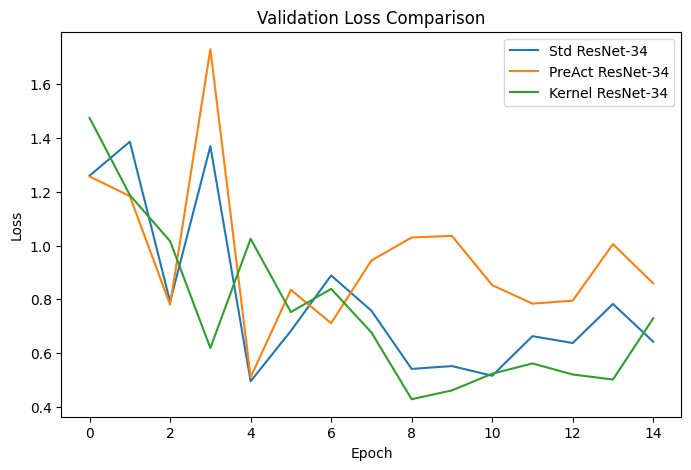

In [21]:
plt.figure(figsize=(8,5))
for name, hist in histories.items():
    plt.plot(hist["val_loss"], label=name)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend(); plt.show()

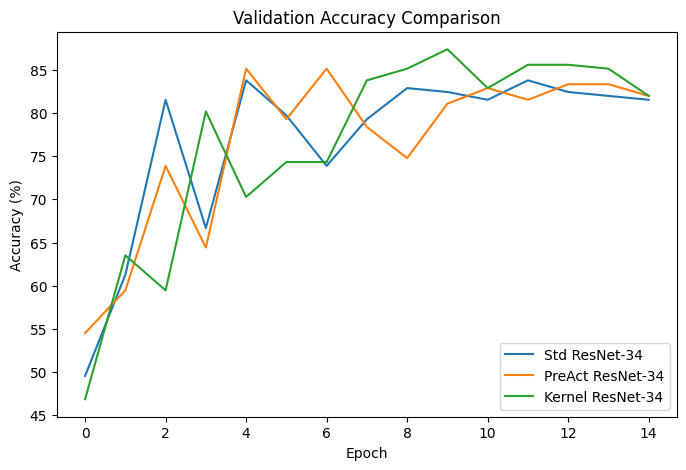

In [22]:
plt.figure(figsize=(8,5))
for name, hist in histories.items():
    plt.plot(hist["val_acc"], label=name)
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend(); plt.show()

In [23]:
summary = {
    "Model": list(histories.keys()),
    "Train Loss": [h["train_loss"][-1] for h in histories.values()],
    "Val Loss":   [h["val_loss"][-1] for h in histories.values()],
    "Train Acc %": [h["train_acc"][-1] for h in histories.values()],
    "Val Acc %":   [h["val_acc"][-1] for h in histories.values()],
    "Params":      [h["params"] for h in histories.values()]
}
df = pd.DataFrame(summary)
print(df.to_string(index=False))

           Model  Train Loss  Val Loss  Train Acc %  Val Acc %   Params
   Std ResNet-34    0.075047  0.642735    97.178330  81.531532 21287237
PreAct ResNet-34    0.125387  0.859330    96.613995  81.981982 21286341
Kernel ResNet-34    0.143805  0.729584    95.598194  81.981982 38654277


In [25]:
for name, hist in histories.items():
    report = hist["report"]  # ini string ASCII
    print(f"\n=== Evaluasi Detail: {name} ===")
    print(report)



=== Evaluasi Detail: Std ResNet-34 ===
              precision    recall  f1-score   support

   gado_gado       0.96      0.57      0.71        46
       bakso       0.84      0.82      0.83        45
     rendang       0.97      0.92      0.95        39
 nasi_goreng       0.85      0.85      0.85        41
   soto_ayam       0.64      0.92      0.76        51

    accuracy                           0.82       222
   macro avg       0.85      0.82      0.82       222
weighted avg       0.85      0.82      0.81       222


=== Evaluasi Detail: PreAct ResNet-34 ===
              precision    recall  f1-score   support

   gado_gado       0.88      0.63      0.73        46
       bakso       0.80      0.98      0.88        45
     rendang       0.89      0.82      0.85        39
 nasi_goreng       0.68      0.93      0.78        41
   soto_ayam       0.93      0.76      0.84        51

    accuracy                           0.82       222
   macro avg       0.83      0.82      0.82     